  - Table of Contents
    - [Imports and CSV Merges](#imports)
    - [Subset High Schools](#iso_hs)
    - [Graduation Rate](#grad_rate)
    - [Numeric Feature Correlation to Target](#corr)
    - [Graduation Rate vs. Total Student Count](#total_students)
    - [Graduation Rate vs. Low Income Student Count](#low_income)
    - [Grades offered](#grade_count)

 - School Type
 - Special Education
 - Options

<a id='imports'></a>

# Imports

In [176]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sys, os
sys.path.append('../..')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
full_path = os.getcwd()
home_folder = 'CPS_GradRate_Analysis'
root = full_path.split(home_folder)[0] + home_folder + '/'

sys.path.append(root)

In [178]:
sys.path.append(root+'src/preprocessing/')

In [179]:
from src.preprocessing.preprocessing_schoolid import load_prepped_school_year_profile, load_unprocessed_hs_df
from src.preprocessing.preprocessing_schoolid import merge_prepped_sy_profile_and_prog_rep
import src.preprocessing.preprocessing_schoolid as data_prep

In [180]:
sys.path.append('../..')

Information about CPS comes from two main files found in the Chicago Data Portal: School Profile Information csv's, School Progress Reports.  The key information from each , as it pertains to this analysis, is described below. The files are merged on School_ID

**School Profile Information File**
  - School_ID
  - Short_Name
  - Graduation_Rate_School
  - Student_Count_Total
  - Is_High_School
  - Dress_Code

**School Progress Report File**
  - School_ID
  - School_Type

    
  
 

In [181]:
path_to_sp_csv = '../../data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Profile_Information_SY1819.csv'

In [182]:
sp_df = pd.read_csv(path_to_sp_csv)
sp_df.shape

(660, 95)

In [183]:
len(sp_df['School_ID'].unique())

660

In [184]:
path_to_pr_csv = '../../data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Progress_Reports_SY1819.csv'
pr_df = pd.read_csv(path_to_pr_csv)

In [185]:
len(pr_df['School_ID'].unique())

654

There are 6 less records in the progress report file. Let's look at which records are different. 

In [186]:
sp_df[~sp_df['School_ID'].isin(pr_df['School_ID'])]

,School_ID,Legacy_Unit_ID,Finance_ID,Short_Name,Long_Name,Primary_Category,Is_High_School,Is_Middle_School,Is_Elementary_School,Is_Pre_School,Summary,Administrator_Title,Administrator,Secondary_Contact_Title,Secondary_Contact,Address,City,State,Zip,Phone,Fax,CPS_School_Profile,Website,Facebook,Twitter,Youtube,Pinterest,Attendance_Boundaries,Grades_Offered_All,Grades_Offered,Student_Count_Total,Student_Count_Low_Income,Student_Count_Special_Ed,Student_Count_English_Learners,Student_Count_Black,Student_Count_Hispanic,Student_Count_White,Student_Count_Asian,Student_Count_Native_American,Student_Count_Other_Ethnicity,Student_Count_Asian_Pacific_Islander,Student_Count_Multi,Student_Count_Hawaiian_Pacific_Islander,Student_Count_Ethnicity_Not_Available,Statistics_Description,Demographic_Description,Dress_Code,PreK_School_Day,Kindergarten_School_Day,School_Hours,Freshman_Start_End_Time,After_School_Hours,Earliest_Drop_Off_Time,Classroom_Languages,Bilingual_Services,Refugee_Services,Title_1_Eligible,PreSchool_Inclusive,Preschool_Instructional,Significantly_Modified,Hard_Of_Hearing,Visual_Impairments,Transportation_Bus,Transportation_El,Transportation_Metra,School_Latitude,School_Longitude,Average_ACT_School,Mean_ACT,College_Enrollment_Rate_School,College_Enrollment_Rate_Mean,Graduation_Rate_School,Graduation_Rate_Mean,Overall_Rating,Rating_Status,Rating_Statement,Classification_Description,School_Year,Third_Contact_Title,Third_Contact_Name,Fourth_Contact_Title,Fourth_Contact_Name,Fifth_Contact_Title,Fifth_Contact_Name,Sixth_Contact_Title,Sixth_Contact_Name,Seventh_Contact_Title,Seventh_Contact_Name,Network,Is_GoCPS_Participant,Is_GoCPS_PreK,Is_GoCPS_Elementary,Is_GoCPS_High_School,Open_For_Enrollment_Date,Closed_For_Enrollment_Date
14,610506,8080,49161,TEAM HS,TEAM Englewood Community Academy High School,HS,True,False,False,False,TEAM Englewood Community Academy is a 21st Cen...,Principal,Denise Michelle Gamble,Assistant Principal,Daena Adams,6201 S STEWART AVE,Chicago,Illinois,60621,7.735354e+09,7.735354e+09,http://cps.edu/Schools/Pages/school.aspx?Schoo...,http://www.teamenglewood.org,https://www.facebook.com/pages/team-englewood-...,https://twitter.com/@TeamEnglewood,NaN,NaN,False,"10,11,12",10-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,There is not any Demographic information for t...,True,NaN,NaN,8:00 AM - 3:13 PM,NaN,NaN,7:30 AM,Spanish,False,False,True,NaN,NaN,NaN,NaN,NaN,"24, 63","Green, Red",NaN,41.781485,-87.633019,NaN,NaN,53.5,68.2,63.0,78.2,Level 3,INTENSIVE SUPPORT,"This school received a Level 3 rating, which i...",These schools limit their student populations ...,School Year 2018-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Network 16,True,False,False,True,07/01/2007 12:00:00 AM,NaN
70,400078,3062,66113,U OF C - WOODSON,University of Chicago - Carter G. Woodson,MS,False,True,False,False,Carter G. Woodson Middle School is dedicated t...,Director,Mr. Jarred Brown,Operations Manager,Carol Love,4444 S EVANS AVE,Chicago,Illinois,60653,7.736241e+09,7.736241e+09,http://cps.edu/Schools/Pages/school.aspx?Schoo...,http://www.uchicagocharter.org/page.cfm?p=525,https://www.facebook.com/UCCharterSchool,http://twitter.com/UCCharterSchool,NaN,NaN,True,8,8,84,57,15,1,84,0,0,0,0,0,0,0,0,0,There are 84 students enrolled at U OF C - WOO...,The largest demographic at U OF C - WOODSON is...,True,NaN,NaN,8:00 AM-3:30 PM,NaN,3:30 PM-5:45 PM,07:30 AM,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,"4, 39, 43, 47",NaN,NaN,41.813547,-87.608426,NaN,NaN,NaN,68.2,NaN,78.2,Level 1,NOT APPLICABLE,"This school received a Level 1 rating, which i...","Schools that are open to all Chicago children,...",School Year 2018-2019,Assistant Operations Manager,Adrienne Bonds,Admissions Director,Carla Scott,Office Manager,Kenya Edwards,NaN,NaN,NaN,NaN,Charter,False,False,False,False,07/01/2008 12:00:00 AM,NaN
80,400087,2490,66171,YOUNG WOMENS HS,Young Women's Leadership Charter School,HS,True,False,False,False,"Young Women's Leadership, Chicago’s only all-g...",Director,Dr. Vanesa S

All of the schools in the school profile csv but not in the progress report have NOT APPLICABLE Rating Status, except 1, which is rated Intensive Support.

The models will be built with only schools that appear in both data files.

In [187]:
pr_df[~pr_df['School_ID'].isin(sp_df['School_ID'])]

,School_ID,Short_Name,Long_Name,School_Type,Primary_Category,Address,City,State,Zip,Phone,Fax,CPS_School_Profile,Website,Progress_Report_Year,Blue_Ribbon_Award_Year,Excelerate_Award_Gold_Year,Spot_Light_Award_Year,Improvement_Award_Year,Excellence_Award_Year,Student_Growth_Rating,Student_Growth_Description,Growth_Reading_Grades_Tested_Pct_ES,Growth_Reading_Grades_Tested_Label_ES,Growth_Math_Grades_Tested_Pct_ES,Growth_Math_Grades_Tested_Label_ES,Student_Attainment_Rating,Student_Attainment_Description,Attainment_Reading_Pct_ES,Attainment_Reading_Lbl_ES,Attainment_Math_Pct_ES,Attainment_Math_Lbl_ES,Culture_Climate_Rating,Culture_Climate_Description,School_Survey_Student_Response_Rate_Pct,School_Survey_Student_Response_Rate_Avg_Pct,School_Survey_Teacher_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Avg_Pct,School_Survey_Parent_Response_Rate_Pct,School_Survey_Parent_Response_Rate_Avg_Pct,Healthy_School_Certification,Healthy_School_Certification_Description,Creative_School_Certification,Creative_School_Certification_Description,NWEA_Reading_Growth_Grade_3_Pct,NWEA_Reading_Growth_Grade_3_Lbl,NWEA_Reading_Growth_Grade_4_Pct,NWEA_Reading_Growth_Grade_4_Lbl,NWEA_Reading_Growth_Grade_5_Pct,NWEA_Reading_Growth_Grade_5_Lbl,NWEA_Reading_Growth_Grade_6_Pct,NWEA_Reading_Growth_Grade_6_Lbl,NWEA_Reading_Growth_Grade_7_Pct,NWEA_Reading_Growth_Grade_7_Lbl,NWEA_Reading_Growth_Grade_8_Pct,NWEA_Reading_Growth_Grade_8_Lbl,NWEA_Math_Growth_Grade_3_Pct,NWEA_Math_Growth_Grade_3_Lbl,NWEA_Math_Growth_Grade_4_Pct,NWEA_Math_Growth_Grade_4_Lbl,NWEA_Math_Growth_Grade_5_Pct,NWEA_Math_Growth_Grade_5_Lbl,NWEA_Math_Growth_Grade_6_Pct,NWEA_Math_Growth_Grade_6_Lbl,NWEA_Math_Growth_Grade_7_Pct,NWEA_Math_Growth_Grade_7_Lbl,NWEA_Math_Growth_Grade_8_Pct,NWEA_Math_Growth_Grade_8_Lbl,NWEA_Reading_Attainment_Grade_2_Pct,NWEA_Reading_Attainment_Grade_2_Lbl,NWEA_Reading_Attainment_Grade_3_Pct,NWEA_Reading_Attainment_Grade_3_Lbl,NWEA_Reading_Attainment_Grade_4_Pct,NWEA_Reading_Attainment_Grade_4_Lbl,NWEA_Reading_Attainment_Grade_5_Pct,NWEA_Reading_Attainment_Grade_5_Lbl,NWEA_Reading_Attainment_Grade_6_Pct,NWEA_Reading_Attainment_Grade_6_Lbl,NWEA_Reading_Attainment_Grade_7_Pct,NWEA_Reading_Attainment_Grade_7_Lbl,NWEA_Reading_Attainment_Grade_8_Pct,NWEA_Reading_Attainment_Grade_8_Lbl,NWEA_Math_Attainment_Grade_2_Pct,NWEA_Math_Attainment_Grade_2_Lbl,NWEA_Math_Attainment_Grade_3_Pct,NWEA_Math_Attainment_Grade_3_Lbl,NWEA_Math_Attainment_Grade_4_Pct,NWEA_Math_Attainment_Grade_4_Lbl,NWEA_Math_Attainment_Grade_5_Pct,NWEA_Math_Attainment_Grade_5_Lbl,NWEA_Math_Attainment_Grade_6_Pct,NWEA_Math_Attainment_Grade_6_Lbl,NWEA_Math_Attainment_Grade_7_Pct,NWEA_Math_Attainment_Grade_7_Lbl,NWEA_Math_Attainment_Grade_8_Pct,NWEA_Math_Attainment_Grade_8_Lbl,School_Survey_Involved_Families,School_Survey_Supportive_Environment,School_Survey_Ambitious_Instruction,School_Survey_Effective_Leaders,School_Survey_Collaborative_Teachers,School_Survey_Safety,Suspensions_Per_100_Students_Year_1_Pct,Suspensions_Per_100_Students_Year_2_Pct,Suspensions_Per_100_Students_Avg_Pct,Misconducts_To_Suspensions_Year_1_Pct,Misconducts_To_Suspensions_Year_2_Pct,Misconducts_To_Suspensions_Avg_Pct,Average_Length_Suspension_Year_1_Pct,Average_Length_Suspension_Year_2_Pct,Average_Length_Suspension_Avg_Pct,Behavior_Discipline_Year_1,Behavior_Discipline_Year_2,School_Survey_School_Community,School_Survey_Parent_Teacher_Partnership,School_Survey_Quality_Of_Facilities,Student_Attendance_Year_1_Pct,Student_Attendance_Year_2_Pct,Student_Attendance_Avg_Pct,Teacher_Attendance_Year_1_Pct,Teacher_Attendance_Year_2_Pct,Teacher_Attendance_Avg_Pct,One_Year_Dropout_Rate_Year_1_Pct,One_Year_Dropout_Rate_Year_2_Pct,One_Year_Dropout_Rate_Avg_Pct,Other_Metrics_Year_1,Other_Metrics_Year_2,Freshmen_On_Track_School_Pct_Year_2,Freshmen_On_Track_CPS_Pct_Year_2,Freshmen_On_Track_School_Pct_Year_1,Freshmen_On_Track_CPS_Pct_Year_1,Graduation_4_Year_School_Pct_Year_2,Graduation_4_Year_CPS_Pct_Year_2,Graduation_4_Year_School_Pct_Year_1,Gradua

As this notebook progresses, functions will be imported from `src/preprocessing/preprocessing_schoolid.py file`.  These functions will preprocess the data in various ways to prepare it for modeling.

The first function will merge the two csv files above into one large dataframe.

In [188]:
from src.preprocessing.preprocessing_schoolid import merge_pr_and_sp

df = merge_pr_and_sp(path_to_sp_csv, path_to_pr_csv)

In [189]:
df.shape

(651, 276)

In [190]:
df.head()

,School_ID,Legacy_Unit_ID,Finance_ID,Short_Name_sp,Long_Name_sp,Primary_Category_sp,Is_High_School,Is_Middle_School,Is_Elementary_School,Is_Pre_School,Summary,Administrator_Title,Administrator,Secondary_Contact_Title,Secondary_Contact,Address_sp,City_sp,State_sp,Zip_sp,Phone_sp,Fax_sp,CPS_School_Profile_sp,Website_sp,Facebook,Twitter,Youtube,Pinterest,Attendance_Boundaries,Grades_Offered_All,Grades_Offered,Student_Count_Total,Student_Count_Low_Income,Student_Count_Special_Ed,Student_Count_English_Learners,Student_Count_Black,Student_Count_Hispanic,Student_Count_White,Student_Count_Asian,Student_Count_Native_American,Student_Count_Other_Ethnicity,Student_Count_Asian_Pacific_Islander,Student_Count_Multi,Student_Count_Hawaiian_Pacific_Islander,Student_Count_Ethnicity_Not_Available,Statistics_Description,Demographic_Description,Dress_Code,PreK_School_Day,Kindergarten_School_Day,School_Hours,Freshman_Start_End_Time,After_School_Hours,Earliest_Drop_Off_Time,Classroom_Languages,Bilingual_Services,Refugee_Services,Title_1_Eligible,PreSchool_Inclusive,Preschool_Instructional,Significantly_Modified,Hard_Of_Hearing,Visual_Impairments,Transportation_Bus,Transportation_El,Transportation_Metra,School_Latitude_sp,School_Longitude_sp,Average_ACT_School,Mean_ACT,College_Enrollment_Rate_School,College_Enrollment_Rate_Mean,Graduation_Rate_School,Graduation_Rate_Mean,Overall_Rating,Rating_Status,Rating_Statement,Classification_Description,School_Year,Third_Contact_Title,Third_Contact_Name,Fourth_Contact_Title,Fourth_Contact_Name,Fifth_Contact_Title,Fifth_Contact_Name,Sixth_Contact_Title,Sixth_Contact_Name,Seventh_Contact_Title,Seventh_Contact_Name,Network,Is_GoCPS_Participant,Is_GoCPS_PreK,Is_GoCPS_Elementary,Is_GoCPS_High_School,Open_For_Enrollment_Date,Closed_For_Enrollment_Date,Short_Name_pr,Long_Name_pr,School_Type,Primary_Category_pr,Address_pr,City_pr,State_pr,Zip_pr,Phone_pr,Fax_pr,CPS_School_Profile_pr,Website_pr,Progress_Report_Year,Blue_Ribbon_Award_Year,Excelerate_Award_Gold_Year,Spot_Light_Award_Year,Improvement_Award_Year,Excellence_Award_Year,Student_Growth_Rating,Student_Growth_Description,Growth_Reading_Grades_Tested_Pct_ES,Growth_Reading_Grades_Tested_Label_ES,Growth_Math_Grades_Tested_Pct_ES,Growth_Math_Grades_Tested_Label_ES,Student_Attainment_Rating,Student_Attainment_Description,Attainment_Reading_Pct_ES,Attainment_Reading_Lbl_ES,Attainment_Math_Pct_ES,Attainment_Math_Lbl_ES,Culture_Climate_Rating,Culture_Climate_Description,School_Survey_Student_Response_Rate_Pct,School_Survey_Student_Response_Rate_Avg_Pct,School_Survey_Teacher_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Avg_Pct,School_Survey_Parent_Response_Rate_Pct,School_Survey_Parent_Response_Rate_Avg_Pct,Healthy_School_Certification,Healthy_School_Certification_Description,Creative_School_Certification,Creative_School_Certification_Description,NWEA_Reading_Growth_Grade_3_Pct,NWEA_Reading_Growth_Grade_3_Lbl,NWEA_Reading_Growth_Grade_4_Pct,NWEA_Reading_Growth_Grade_4_Lbl,NWEA_Reading_Growth_Grade_5_Pct,NWEA_Reading_Growth_Grade_5_Lbl,NWEA_Reading_Growth_Grade_6_Pct,NWEA_Reading_Growth_Grade_6_Lbl,NWEA_Reading_Growth_Grade_7_Pct,NWEA_Reading_Growth_Grade_7_Lbl,NWEA_Reading_Growth_Grade_8_Pct,NWEA_Reading_Growth_Grade_8_Lbl,NWEA_Math_Growth_Grade_3_Pct,NWEA_Math_Growth_Grade_3_Lbl,NWEA_Math_Growth_Grade_4_Pct,NWEA_Math_Growth_Grade_4_Lbl,NWEA_Math_Growth_Grade_5_Pct,NWEA_Math_Growth_Grade_5_Lbl,NWEA_Math_Growth_Grade_6_Pct,NWEA_Math_Growth_Grade_6_Lbl,NWEA_Math_Growth_Grade_7_Pct,NWEA_Math_Growth_Grade_7_Lbl,NWEA_Math_Growth_Grade_8_Pct,NWEA_Math_Growth_Grade_8_Lbl,NWEA_Reading_Attainment_Grade_2_Pct,NWEA_Reading_Attainment_Grade_2_Lbl,NWEA_Reading_Attainment_Grade_3_Pct,NWEA_Reading_Attainment_Grade_3_Lbl,NWEA_Reading_Attainment_Grade_4_Pct,NWEA_Reading_Attainment_Grade_4_Lbl,NWEA_Reading_Attainment_Grade_5_Pct,NWEA_Reading_Attainment_Grade_5_Lbl,NWEA_Reading_Attainment_Grade_6_Pct,NWEA_Reading_Attainment_Grade_6_Lbl,NWEA_Reading_Attainment_Grade_7_Pct,NWEA_Readi

<a id='iso_hs'></a>

# Isolate High Schools

Since the original target of the models will be graduation rates, I will be able to use high school records.

In [191]:
from src.preprocessing.preprocessing_schoolid import isolate_high_schools

In [192]:
df = isolate_high_schools(df)

In [193]:
df.shape

(176, 276)

## Graduation Rates

After merging both data sets, there are 176 high schools available. Of these high schools, only ones which report graduation rates are suitable for modeling.  The function below drops any high schools without graduation rates.

In [194]:
from src.preprocessing.preprocessing_schoolid import drop_no_gr_schools

df = drop_no_gr_schools(df)

The distribution of graduation rates is left skewed, as seen in the histogram below.  

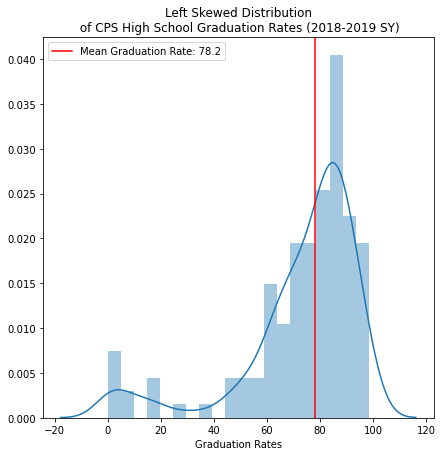

In [195]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(7,7))

sns.distplot(df['Graduation_Rate_School'], bins=20, ax=ax)

ax.set_title('Left Skewed Distribution\n of CPS High School Graduation Rates (2018-2019 SY)')
ax.set_xlabel('Graduation Rates')
ax.axvline(df['Graduation_Rate_Mean'].mean(), color='r')
ax.legend(labels = [f"Mean Graduation Rate: {df['Graduation_Rate_Mean'].mean()}" ]);

In [196]:
df['Graduation_Rate_School'].skew()

-1.8122461470300288

There are several types of schools which have very low graduation rates. This information is included in the **school_progrest report csv**.

## School Type

There are 10 unique high school school types in the data set.

In [197]:
len(df['School_Type'].unique())

10

In [198]:
df['School_Type'].value_counts().sort_index()

Career academy           4
Charter                 39
Citywide-Option         10
Contract                 2
Magnet                   6
Military academy         5
Neighborhood            44
Selective enrollment    11
Small                   13
Special Education        2
Name: School_Type, dtype: int64

Of these school types, Special Education and Citywide-Option schools have mean graduation rates below 20%.

In [199]:
df.groupby('School_Type').agg(['mean', 'std', 'count'])['Graduation_Rate_School'].sort_values('mean')

,mean,std,count
School_Type,,,
Special Education,9.600000,13.576450,2
Citywide-Option,17.290000,27.109058,10
Neighborhood,70.556818,13.728165,44
Small,77.330769,10.304803,13
Charter,79.641026,8.970059,39
Career academy,80.900000,11.110956,4
Contract,83.450000,1.343503,2
Magnet,87.933333,6.245852,6
Military academy,89.180000,5.389527,5


For modeling, I will drop special education schools, as their missions differ from non-special education schools, and there are so few of them. 

The Citywide-Options are specifically designed to help re-engage students who are at risk for not graduating.  They have previously disengaged from school in some manner, and these schools are trying to reengage them. 

[Citywide-Options](https://www.cps.edu/schools/re-engagement-to-high-school/)

For initial modeling, I will drop these schools, since their graduation rate skews the distribution left. But, the function below will also allow for us to not drop them for modeling experimentation with them included.

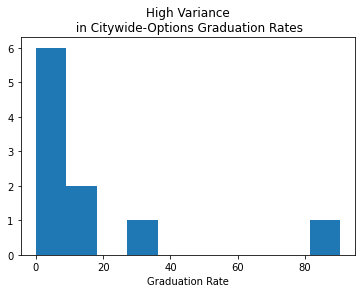

In [200]:
fig, ax = plt.subplots()
options = df[df['School_Type'] == 'Citywide-Option']['Graduation_Rate_School']
ax.hist(options)
ax.set_title('High Variance\n in Citywide-Options Graduation Rates')
ax.set_xlabel('Graduation Rate');

In [201]:
from src.preprocessing.preprocessing_schoolid import drop_specialed_options

df = drop_specialed_options(df, drop_options=True)

In [202]:
df['School_Type'].unique()

array(['Military academy', 'Charter', 'Selective enrollment', 'Contract',
       'Neighborhood', 'Magnet', 'Small', 'Career academy'], dtype=object)

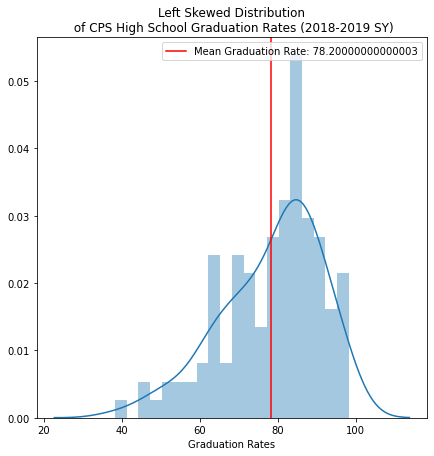

In [203]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(7,7))

sns.distplot(df['Graduation_Rate_School'], bins=20, ax=ax)

ax.set_title('Left Skewed Distribution\n of CPS High School Graduation Rates (2018-2019 SY)')
ax.set_xlabel('Graduation Rates')
ax.axvline(df['Graduation_Rate_School'].mean(), color='r')
ax.legend(labels = [f"Mean Graduation Rate: {df['Graduation_Rate_Mean'].mean()}" ]);

The distribution is still left skewed, but less so than before.

In [212]:
df['Graduation_Rate_School'].skew()

-0.7531512993623227

# Numeric Feature Correlation to the Target

The print out below is a lot to take in, but we will zero in on some interesting correlations.

In [250]:
corr = df.corr()['Graduation_Rate_School'].sort_values(ascending=False)
for corr, ind in zip(corr, corr.index ):
    print(corr, ind)

1.0 Graduation_Rate_School
1.0 Graduation_5_Year_School_Pct_Year_2
0.9807694011380437 Graduation_4_Year_School_Pct_Year_1
0.9398062922392656 NWEA_Math_Attainment_Grade_5_Pct
0.9378439015802073 NWEA_Reading_Growth_Grade_3_Pct
0.9026202371320136 NWEA_Math_Attainment_Grade_4_Pct
0.8946948361593215 Graduation_5_Year_School_Pct_Year_1
0.863493261689572 Graduation_4_Year_School_Pct_Year_2
0.7820778680955914 Student_Attendance_Year_1_Pct
0.7582954174478616 NWEA_Reading_Attainment_Grade_4_Pct
0.7539064663500863 Student_Attendance_Year_2_Pct
0.7263818447292939 College_Persistence_School_Pct_Year_2
0.7125290449270587 Attainment_All_Grades_School_Pct
0.7125290449270587 Attainment_All_Grades_School_Lbl
0.7083327754140356 Attainment_PSAT_Grade_9_School_Lbl
0.7083327754140356 Attainment_PSAT_Grade_9_School_Pct
0.7014836964040838 College_Enrollment_School_Pct_Year_1
0.7001105851550068 SAT_Grade_11_Score_School_Avg
0.6985902363179537 PSAT_Grade_9_Score_School_Avg
0.6934833261797885 Attainment_SAT_Grad

It is easier to view the correlations when just inspecting the school profile dataframe.

<a id='total_students'></a>

# Total Students

> Does how more total students correlate with higher or lower graduation rates?

> There was one 2018-2019 school whose records had no student counts?

In the output above, total number of students has a high correlation to the target.  I am interested in finding out whether number of students in a school can effectively model graduation rates.

In [251]:
df['Student_Count_Total'].value_counts().sort_index()

21      1
61      1
84      1
85      1
104     1
       ..
2094    1
2205    1
2859    1
3294    1
4494    1
Name: Student_Count_Total, Length: 120, dtype: int64

> These have been removed in the final dataframe

The high schools include in the sample have a mean of 621 students.

In [256]:
hs_1819['Student_Count_Total'].mean()

621.9545454545455

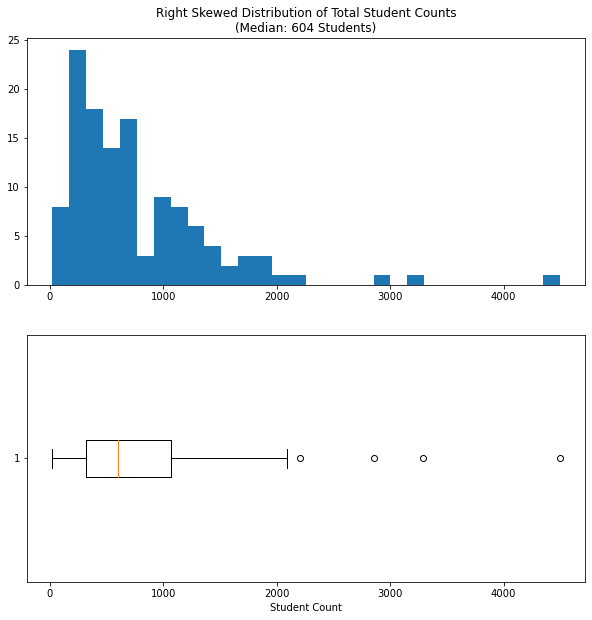

In [258]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].hist(df['Student_Count_Total'], bins=30)
ax[1].boxplot(df['Student_Count_Total'], vert=False)
ax[0].set_title(f"""Right Skewed Distribution of Total Student Counts
(Median: {round(df['Student_Count_Total'].median())} Students)""")
ax[1].set_xlabel('Student Count');

Text(0, 0.5, 'Graduation Rate')

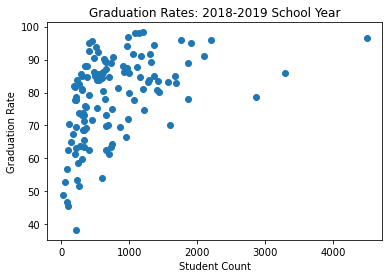

In [260]:
fig, ax = plt.subplots()
ax.scatter(df['Student_Count_Total'], df['Graduation_Rate_School'])
ax.set_title('Graduation Rates: 2018-2019 School Year')
ax.set_xlabel('Student Count')
ax.set_ylabel('Graduation Rate')

> There are a few schools with very low graduation rates which also have very low student counts. 

> There appears to be a positive correlation between total students and graduation rate, which is reinforced by the .4345 correlation below.

In [156]:
hs_1819[['Graduation_Rate_School', 'Student_Count_Total']].corr()

,Graduation_Rate_School,Student_Count_Total
Graduation_Rate_School,1.00000,0.43358
Student_Count_Total,0.43358,1.00000


> There also appears a curvature to the relationship, which may suggest the inclusion of a polynomial term in the model

In [157]:
hs_1819['student_count^2'] = hs_1819['Student_Count_Total']**2

In [158]:
hs_1819[['student_count^2', 'Graduation_Rate_School']].corr()

,student_count^2,Graduation_Rate_School
student_count^2,1.000000,0.258679
Graduation_Rate_School,0.258679,1.000000


> Basic correlation with squared term shows some correlation

<a id='low_income'></a>

# Does Number of low income students correlate with lower or higher graduation rates?

In [162]:
hs_1819['Student_Count_Low_Income'].sort_values()

24       18
5        34
179      50
61       70
357      75
       ... 
652    1523
520    1602
500    1752
634    1951
645    2536
Name: Student_Count_Low_Income, Length: 140, dtype: int64

In [160]:
dfhs_201819['Student_Count_Low_Income'].hist()

NameError: name 'dfhs_201819' is not defined

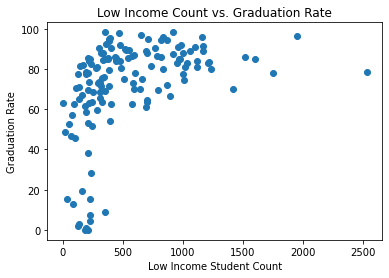

In [47]:
fig, ax = plt.subplots()
ax.scatter(dfhs_201819['Student_Count_Low_Income'], dfhs_201819['Graduation_Rate_School'])
ax.set_title('Low Income Count vs. Graduation Rate')
ax.set_xlabel('Low Income Student Count')
ax.set_ylabel('Graduation Rate');

In [48]:
dfhs_201819[['Student_Count_Low_Income','Graduation_Rate_School']].corr()

,Student_Count_Low_Income,Graduation_Rate_School
Student_Count_Low_Income,1.000000,0.425583
Graduation_Rate_School,0.425583,1.000000


There is a positive correlation between low income student count and graduation rate.  The scatter plot is very similar to the plot of Total students to low income students,.

In [49]:
dfhs_201819[['Student_Count_Low_Income','Student_Count_Total']].corr()

,Student_Count_Low_Income,Student_Count_Total
Student_Count_Low_Income,1.000000,0.898967
Student_Count_Total,0.898967,1.000000


As we see from the correlation above, there is a strong positive correlation between total student count and low income student count. 

Intuitively, the more students there are in a school, the more low income students there are.

## Percent Low Income

In [50]:
# Calculate % low income
dfhs_201819['perc_low_income'] = dfhs_201819['Student_Count_Low_Income']/dfhs_201819['Student_Count_Total']

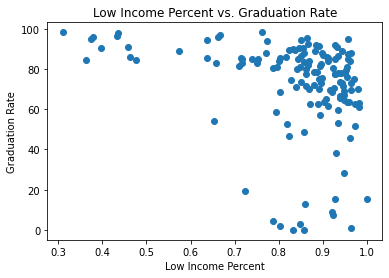

In [51]:
fig, ax = plt.subplots()
ax.scatter(dfhs_201819['perc_low_income'], dfhs_201819['Graduation_Rate_School'])
ax.set_title('Low Income Percent vs. Graduation Rate')
ax.set_xlabel('Low Income Percent')
ax.set_ylabel('Graduation Rate');

In [52]:
dfhs_201819[['perc_low_income','Graduation_Rate_School']].corr()

,perc_low_income,Graduation_Rate_School
perc_low_income,1.0000,-0.2877
Graduation_Rate_School,-0.2877,1.0000


As one would expect, schools that service less affluent communities show lower graduation rates. 
In other words, as the percentage of low income students goes down, the graduation rate of the school goes up.  

In [ ]:
# I will feature engineer percent low income within the preprocessing py file.

In [53]:
dfhs_201819[['perc_low_income','Student_Count_Total']].corr()

,perc_low_income,Student_Count_Total
perc_low_income,1.000000,-0.505144
Student_Count_Total,-0.505144,1.000000


There is a negative correlation between percentage low income students and total student count.  As the student population grows, there is a lower ratio of low income students to high income students.  In other words, schools with smaller populations tend to have larger relative proportions of low-income students.

> I'll begin investigating the difference between schools that fall into two bins

## Binning Low Income Populations

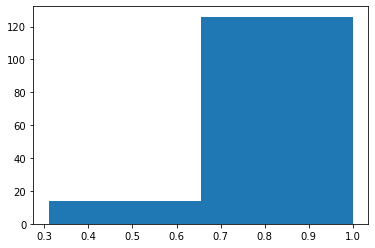

In [54]:
fig, ax = plt.subplots()

hist_2bin = ax.hist(dfhs_201819['perc_low_income'], bins=2)

In [55]:
hist_2bin[1][1]

0.6547826086956521

In [56]:
# Set high_low_inc value to a binary where 1 is > the separation of the binary histogram
dfhs_201819['high_low_inc'] = dfhs_201819['perc_low_income'].apply(lambda x: x > hist_2bin[1][1]).astype(int)

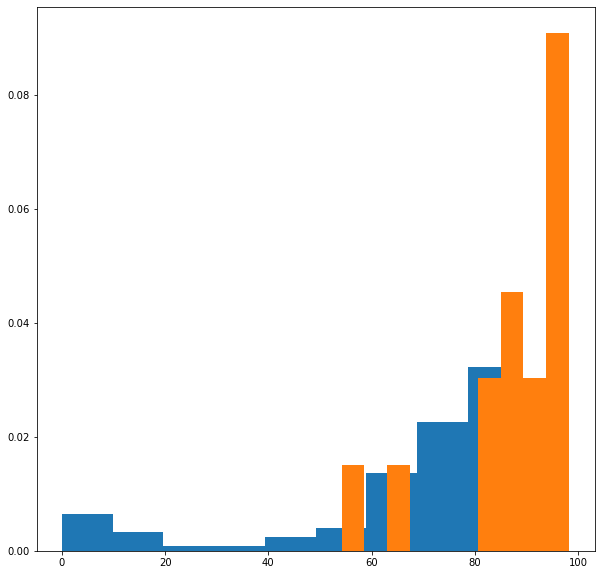

In [57]:
high_low_inc, ax = plt.subplots(figsize=(10,10))
high_low_inc_gradrates = dfhs_201819[dfhs_201819['high_low_inc']==1]['Graduation_Rate_School']
low_low_inc_gradrates = dfhs_201819[dfhs_201819['high_low_inc']==0]['Graduation_Rate_School']

ax.hist(high_low_inc_gradrates, density=True)
ax.hist(low_low_inc_gradrates, density=True);

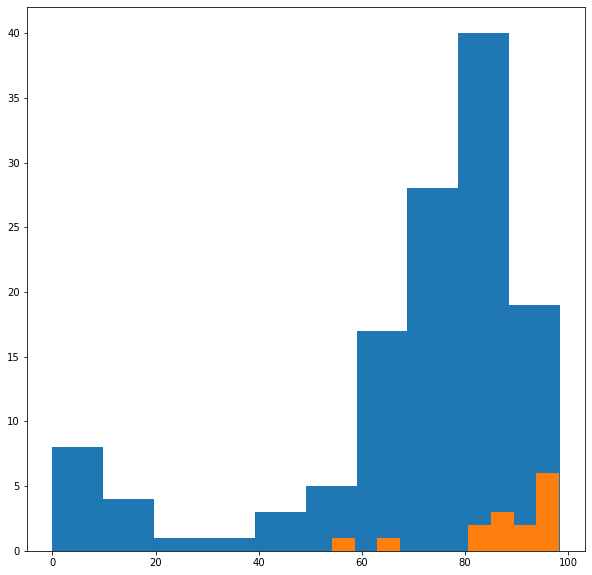

In [58]:
high_low_inc, ax = plt.subplots(figsize=(10,10))
high_low_inc_gradrates = dfhs_201819[dfhs_201819['high_low_inc']==1]['Graduation_Rate_School']
low_low_inc_gradrates = dfhs_201819[dfhs_201819['high_low_inc']==0]['Graduation_Rate_School']

ax.hist(high_low_inc_gradrates, density=False)
ax.hist(low_low_inc_gradrates, density=False);

> This grouping has too great a class imbalance to prove useful, most likely. 

I will try a grouping of high and low with the groupings split according to the histogram below.

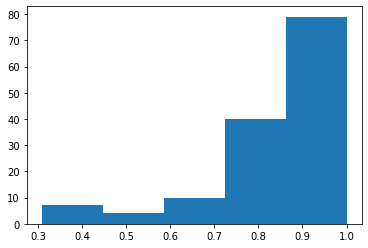

In [59]:
fig, ax = plt.subplots()

low_inc_5bins = ax.hist(dfhs_201819['perc_low_income'], bins=5)

In [60]:
low_inc_5bins[1][-2]

0.8619130434782609

In [61]:
dfhs_201819['high_low_inc_5bins'] = dfhs_201819['perc_low_income'].apply(lambda x: x > low_inc_5bins[1][-2]).astype(int)

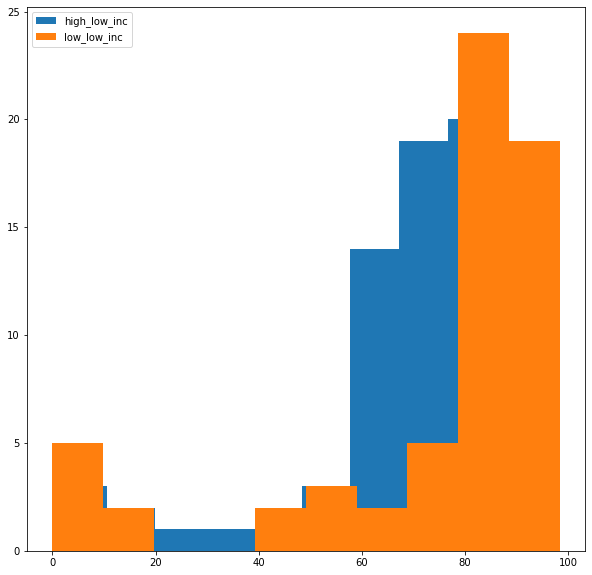

In [62]:
high_low_inc, ax = plt.subplots(figsize=(10,10))
high_low_inc_gradrates = dfhs_201819[dfhs_201819['high_low_inc_5bins']==1]['Graduation_Rate_School']
low_low_inc_gradrates = dfhs_201819[dfhs_201819['high_low_inc_5bins']==0]['Graduation_Rate_School']

ax.hist(high_low_inc_gradrates, density=False, label='high_low_inc')
ax.hist(low_low_inc_gradrates, density=False, label='low_low_inc')
ax.legend();

This looks a bit more interesting.  There is a better class balance and there does appear to be a difference in these distributions.

In [63]:
high_low_inc_gradrates.mean()

70.14810126582277

In [64]:
low_low_inc_gradrates.mean()

74.19354838709677

# Dress Code

Does a dress code improve graduation rate?

In [84]:
df_201819[df_201819['Dress_Code'] == True]['Graduation_Rate_School'].mean()

73.48817204301075

In [85]:
df_201819[df_201819['Dress_Code'] == False]['Graduation_Rate_School'].mean()

68.90208333333334

In [81]:
from scipy.stats import ttest_ind

ttest_ind(df_201819[df_201819['Dress_Code'] == 1]['Graduation_Rate_School'],
          df_201819[df_201819['Dress_Code'] == 0]['Graduation_Rate_School'])

Ttest_indResult(statistic=1.0927918629778086, pvalue=0.2763755309208247)

> T-test doesn't show significant difference in graduation rates.


<a id='grade_count'></a>

## Grades Offered

## Does Number of Grades offered affect graduation rate?

<a id='pr_report'></a>